[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1lg7IjKrMKyCkrqq4xffviw7DaOac-I3y?usp=sharing)

# A Simple implementation of the ReAct Agents with Porktey
This notebook has been forked from Simon Willison's implementation of simple Python implementation of the ReAct pattern for LLMs-  https://til.simonwillison.net/llms/python-react-pattern.

ReACT (Reasoning and Action) agent is a framework designed to integrate the reasoning capabilities of large language models (LLMs) with the ability to take actionable steps, creating a more systematic system that can understand and process information, evaluate decisions, take appropriate actions, communicate responses, and track actions.


[Portkey](https://portkey.ai) helps you grain granular insights into your Agents workflow
Key Features. By routing your agent's requests through Portkey, you gain access to the following production-grade features:

1. **Interoperability**
- Easily switch between 200+ LLMs
- Call various LLMs (Anthropic, Gemini, Mistral, Azure OpenAI, Google Vertex AI, AWS Bedrock, and more)
- Choose the best LLM for your ReAct based agent

2. **Observability**
- Get granular insights into cost, tokens used, and latency using Portkey for understanding ReAct agents' performance
- Helps you identify bottlenecks and optimize resource usage


3. **Reliability**
-  Long ReAct pipelines with multiple API calls can fail at any stage, disrupting the entire process.
- Portkey offers built-in fallbacks between different LLMs or providers
- Implements load-balancing across multiple instances or API keys
- Provides automatic retries and request timeouts
- Makes ReAct more reliable and resilient


4. **Caching** (simple & semantic)
- Store frequently accessed data to reduce expensive API calls
- Portkey offers Simple and Semantics caching for your ReAct agents.

5. **Logs**
- ReAct run is complex. Logs are essential for diagnosing issues, understanding LLMs behavior, and improving performance.
- Portkey provides detailed records of actions and tool use
- Crucial for debugging and managing complex ReAct runs

6. **Prompt Management**
- Manage ReAct Prompts in Portkey's Prompt Library
- Try new versions of Prompts without changing code
- Utilize Portkey's inbuilt Prompt Management Suite


For more information on how to use these features please refer to the [Portkey documentation](https://docs.portkey.ai/docs).

## Installing Dependencies

In [ ]:
!pip install portkey-ai openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 406.0/406.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.0/337.0 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.3 MB/s eta 0:00:00


## Importing Libraries

In [ ]:
import re
import httpx

from openai import OpenAI
from portkey_ai import PORTKEY_GATEWAY_URL, createHeaders


## Creating A Basic ReAct agent with Portkey

In [ ]:
client = OpenAI(
    api_key="OPENAI_API_KEY", #Enter your OpenAI API Key
    base_url=PORTKEY_GATEWAY_URL,
    default_headers=createHeaders(
        provider="openai",
        api_key="PORTKEY_API_KEY", #Enter your Portkey API Key
        trace_id="react-agent" #Trace ID for agent
    )
)


class ChatBot:
    def __init__(self, system=""):
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})

    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result

    def execute(self):
        completion = client.chat.completions.create(model="gpt-3.5-turbo", messages=self.messages)

        return completion.choices[0].message.content

prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

wikipedia:
e.g. wikipedia: Django
Returns a summary from searching Wikipedia

simon_blog_search:
e.g. simon_blog_search: Django
Search Simon's blog for that term

Always look things up on Wikipedia if you have the opportunity to do so.

Example session:

Question: What is the capital of France?
Thought: I should look up France on Wikipedia
Action: wikipedia: France
PAUSE

You will be called again with this:

Observation: France is a country. The capital is Paris.

You then output:

Answer: The capital of France is Paris
""".strip()


action_re = re.compile('^Action: (\w+): (.*)$')

def query(question, max_turns=5):
    i = 0
    bot = ChatBot(prompt)
    next_prompt = question
    while i < max_turns:
        i += 1
        result = bot(next_prompt)
        print(result)
        actions = [action_re.match(a) for a in result.split('\n') if action_re.match(a)]
        if actions:
            # There is an action to run
            action, action_input = actions[0].groups()
            if action not in known_actions:
                raise Exception("Unknown action: {}: {}".format(action, action_input))
            print(" -- running {} {}".format(action, action_input))
            observation = known_actions[action](action_input)
            print("Observation:", observation)
            next_prompt = "Observation: {}".format(observation)
        else:
            return


def wikipedia(q):
    return httpx.get("https://en.wikipedia.org/w/api.php", params={
        "action": "query",
        "list": "search",
        "srsearch": q,
        "format": "json"
    }).json()["query"]["search"][0]["snippet"]


def simon_blog_search(q):
    results = httpx.get("https://datasette.simonwillison.net/simonwillisonblog.json", params={
        "sql": """
        select
          blog_entry.title || ': ' || substr(html_strip_tags(blog_entry.body), 0, 1000) as text,
          blog_entry.created
        from
          blog_entry join blog_entry_fts on blog_entry.rowid = blog_entry_fts.rowid
        where
          blog_entry_fts match escape_fts(:q)
        order by
          blog_entry_fts.rank
        limit
          1""".strip(),
        "_shape": "array",
        "q": q,
    }).json()
    return results[0]["text"]

def calculate(what):
    return eval(what)

known_actions = {
    "wikipedia": wikipedia,
    "calculate": calculate,
    "simon_blog_search": simon_blog_search
}

## Asking the Query and Output

In [ ]:
query("What does India share borders with?")

Thought: I should look up India on Wikipedia to find information about its neighboring countries.
Action: wikipedia: India
PAUSE
 -- running wikipedia India
Observation: <span class="searchmatch">India</span>, officially the Republic of <span class="searchmatch">India</span> (ISO: Bhārat Gaṇarājya), is a country in South Asia. It is the seventh-largest country by area; the most populous
Answer: India shares its borders with several countries in South Asia.


## Observability with Portkey



By routing requests through Portkey you can track a number of metrics like - tokens used, latency, cost, etc.

Here's a screenshot of the dashboard you get with Portkey!

![portkey_view.JPG](https://portkey.ai/blog/content/images/2024/07/Screenshot-2024-07-01-at-12.38.28-PM.png)

## **Logs**
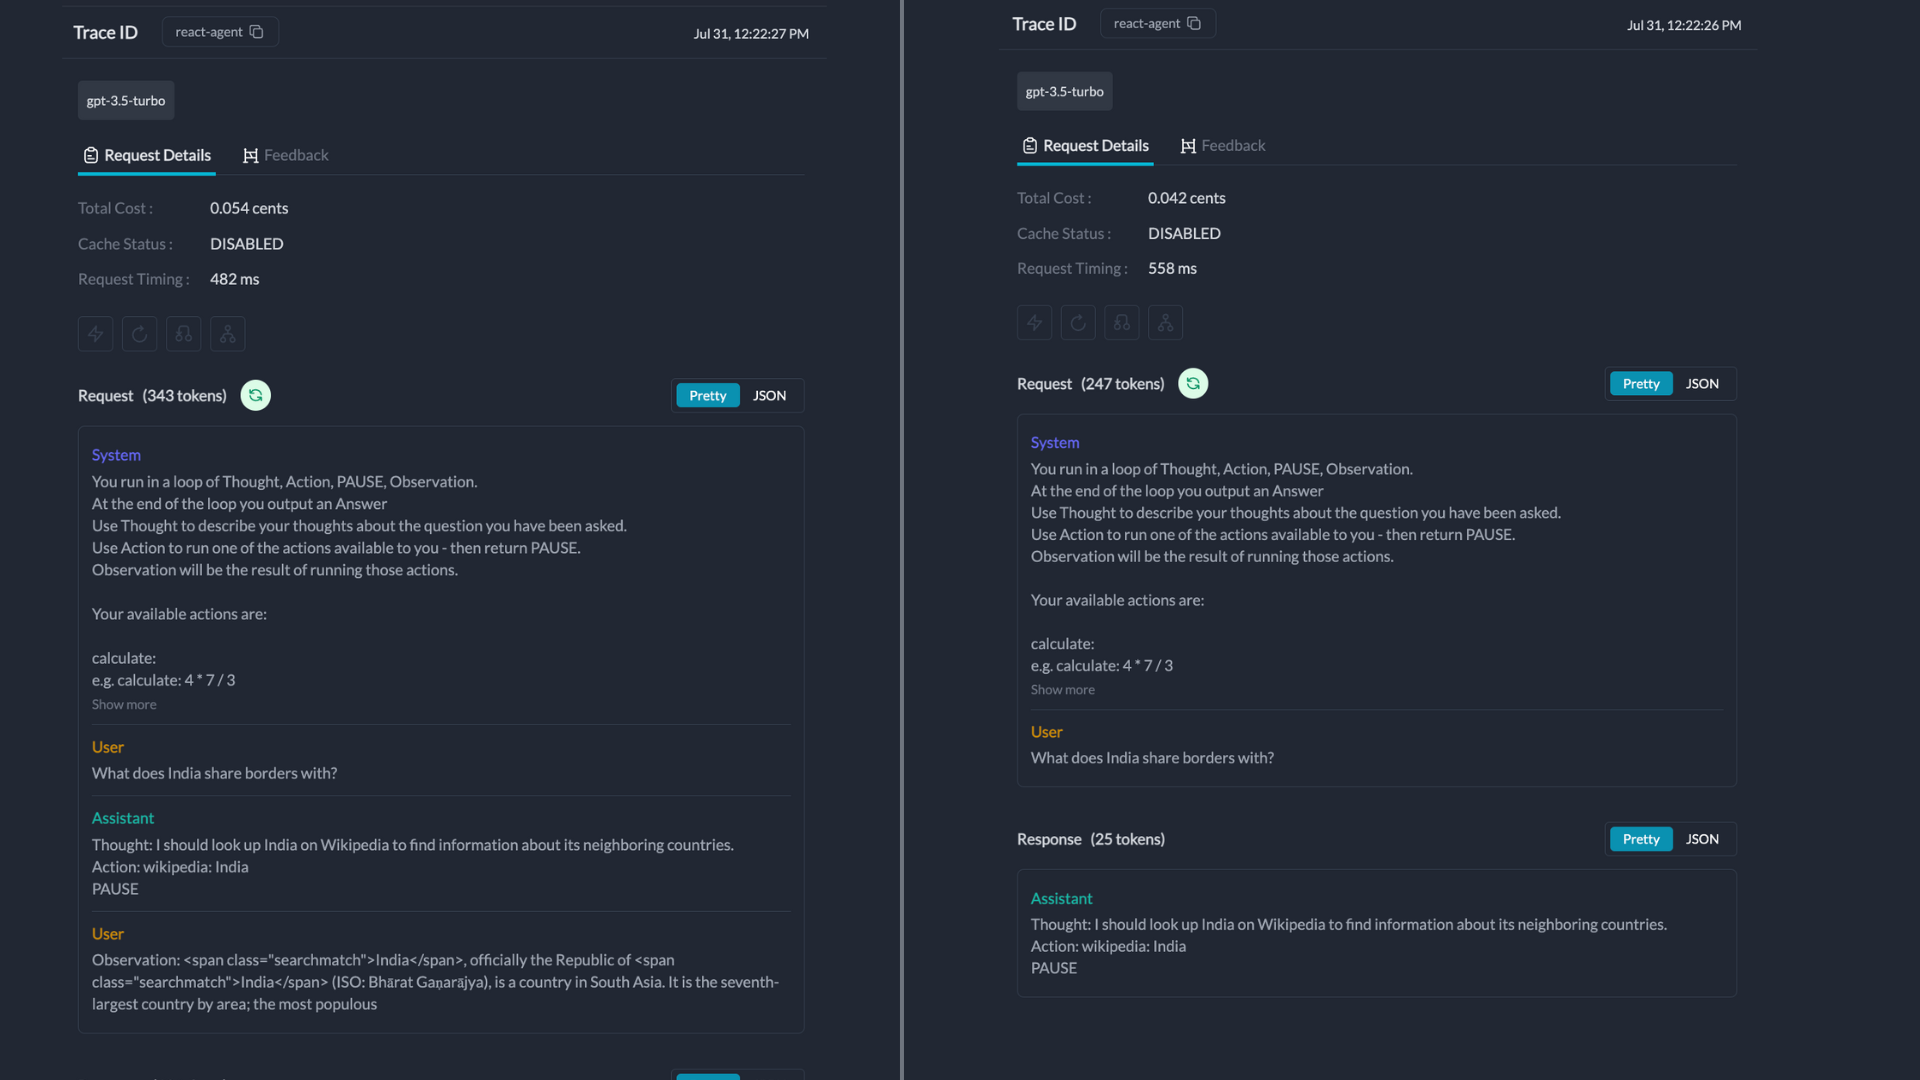